In [1]:
import pandas as pd

df = pd.read_csv('../../preprocessed.csv')

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
grouped = df.groupby('remote_host')

In [6]:
remote_hosts_ordered = [remote_host for remote_host, _ in grouped]
#print(remote_hosts_ordered)

In [8]:
import numpy as np
max_timesteps = 20
sequences = []
for remote_host, group_data in grouped:
    # drop 'remote_host' column as it's no longer needed for individual sequences
    group_data = group_data.drop(columns=['remote_host'])
    
    # convert the DataFrame to numpy array
    sequence_array = group_data.to_numpy()
    
    # pad the sequence with zeros if it's shorter than max_timesteps
    padded_sequence = pad_sequences([sequence_array], maxlen=max_timesteps, dtype='float32', padding='post', truncating='post')
    
    # append the padded sequence to the list of sequences
    sequences.append(padded_sequence)

# stack all sequences to create the final input array for the LSTM
X = np.vstack(sequences)


In [9]:
print(X[0])

[[-7.95538723e-02  2.41719623e-04  0.00000000e+00 -1.19185217e-01
   2.58819044e-01 -9.65925813e-01 -6.69130623e-01 -7.43144810e-01
   0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.78533173e-01  1.84416022e-05  9.10599530e-01 -1.19185217e-01
   2.58819044e-01 -9.65925813e-01 -6.69130623e-01 -7.43144810e-01
   1.04528464e-01  9.94521916e-01  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.86653161e-01  6.32053241e-04  9.10599530e-01 -1.19185217e-01
   2.58819044e-01 -9.65925813e-01 -6.69130623e-01 -7.43144810e-01
   1.04528464e-01  9.94521916e-01  1.0

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

# X is input data
input_shape = X.shape[1:] # get shape of input data

model = Sequential([
    LSTM(100, activation='relu', input_shape=input_shape, return_sequences=True),
    LSTM(100, activation='relu', return_sequences=True),
    TimeDistributed(Dense(input_shape[-1])) # reconstruct input
])

model.compile(optimizer='adam', loss='mse')

In [22]:
history = model.fit(X_train, X_train, epochs=6, batch_size=32, validation_data=(X_val, X_val))

Epoch 1/6
502/502 [==============================] - 51s 102ms/step - loss: 7.2568e-05 - val_loss: 6.7154e-05
Epoch 2/6
502/502 [==============================] - 51s 102ms/step - loss: 9.3204e-05 - val_loss: 4.2083e-05
Epoch 3/6
502/502 [==============================] - 51s 102ms/step - loss: 7.5387e-05 - val_loss: 1.0200e-04
Epoch 4/6
502/502 [==============================] - 51s 101ms/step - loss: 5.5113e-05 - val_loss: 6.2361e-05
Epoch 5/6
502/502 [==============================] - 51s 102ms/step - loss: 6.9440e-05 - val_loss: 3.1505e-05
Epoch 6/6
502/502 [==============================] - 51s 102ms/step - loss: 4.7086e-05 - val_loss: 5.1085e-05


In [23]:
val_loss = model.evaluate(X_val, X_val)
print(f"Validation Loss: {val_loss}")

126/126 [==============================] - 2s 19ms/step - loss: 5.1085e-05
Validation Loss: 5.108536424813792e-05


In [24]:
# predict the reconstruction of the input for each sequence
reconstructions = model.predict(X)

# calculate the reconstruction error for each sequence
reconstruction_error = np.mean(np.square(X - reconstructions), axis=(1, 2))

# set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 99.9) # we're looking for exceptions

# identify anomalies
anomalies = reconstruction_error > threshold

628/628 [==============================] - 12s 18ms/step


In [25]:
anomalous_remote_hosts = [remote_hosts_ordered[i] for i, is_anomaly in enumerate(anomalies) if is_anomaly]

In [26]:
print("Anomalous remote hosts:", anomalous_remote_hosts)

Anomalous remote hosts: ['139.47.117.125', '159.65.255.51', '185.36.81.42', '188.126.89.79', '2.11.2.62', '34.118.178.152', '34.32.212.246', '34.89.222.112', '35.145.4.24', '35.199.6.114', '50.66.182.197', '62.122.184.194', '64.124.8.34', '64.124.8.40', '64.43.50.40', '66.45.237.154', '77.226.251.249', '79.154.21.148', '81.165.56.148', '82.147.85.78', '91.92.245.67']


In [27]:
remote_host_errors = {remote_host: error for remote_host, error in zip(remote_hosts_ordered, reconstruction_error)}

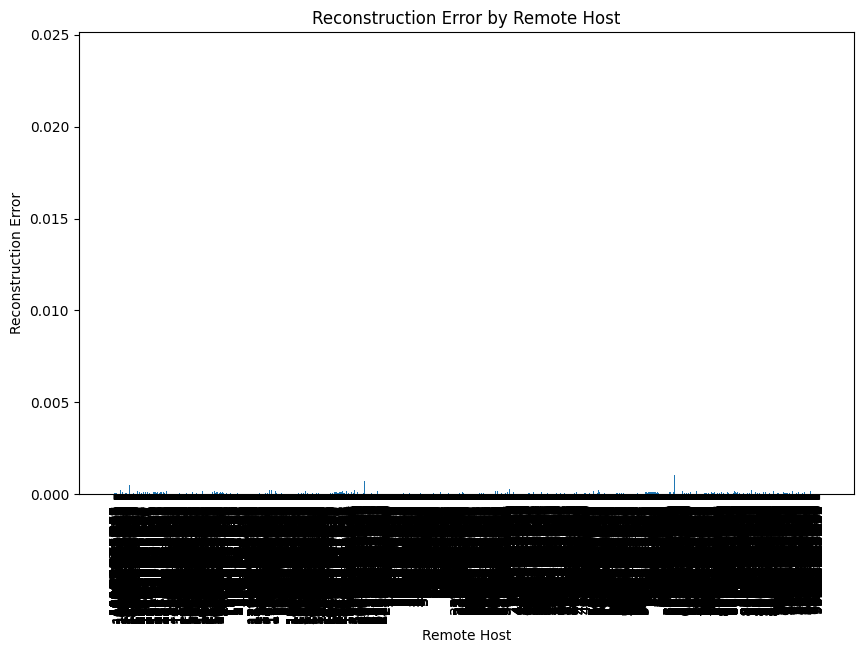

In [28]:
import matplotlib.pyplot as plt

# extract remote_host identifiers and their corresponding errors
remote_host_ids = list(remote_host_errors.keys())
errors = list(remote_host_errors.values())

# create a bar plot of the reconstruction errors
plt.figure(figsize=(10, 6))
plt.bar(remote_host_ids, errors)
plt.xlabel('Remote Host')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error by Remote Host')
plt.xticks(rotation=90) # rotate x-axis labels for better readability
plt.show()